In [38]:
import glob
import pandas as pd
import json

projects = ["djanjo", "flask", "pytorch", "pandas"]
dfs=[]

for project in projects:
    filenames = glob.glob(f"../output/pytlint/{project}/*.json")
    for filename in filenames:
        with open(filename) as json_data:
            data = json.load(json_data)
            df = pd.json_normalize(data)
            df['project'] = project
            dfs.append(df)




In [39]:
df_py = pd.concat(dfs, ignore_index=True)

df_py.head(5)

,type,module,obj,line,column,endLine,endColumn,path,symbol,message,message-id,project
0,warning,flask.cli,FlaskGroup.list_commands,605,15,605,24,projects/py/flask/src/flask/cli.py,broad-except,Catching too general exception Exception,W0703,flask
1,warning,flask.cli,run_command,898,11,898,20,projects/py/flask/src/flask/cli.py,broad-except,Catching too general exception Exception,W0703,flask
2,warning,test_reqctx,test_teardown_with_previous_exception,39,11,39,20,projects/py/flask/tests/test_reqctx.py,broad-except,Catching too general exception Exception,W0703,flask
3,warning,test_reqctx,test_teardown_with_handled_exception,58,15,58,24,projects/py/flask/tests/test_reqctx.py,broad-except,Catching too general exception Exception,W0703,flask
4,warning,test_appctx,test_app_tearing_down_with_previous_exception,66,11,66,20,projects/py/flask/tests/test_appctx.py,broad-except,Catching too general exception Exception,W0703,flask


In [40]:
df_py.groupby(['project','message-id'])['message-id'].count()

project  message-id
flask    W0703           9
pandas   W0703          24
         W0706           2
         W0707          23
pytorch  E0702           5
         E0704           2
         W0702           4
         W0703         253
         W0706           6
         W0707           9
         W0715          11
Name: message-id, dtype: int64

In [41]:
import psycopg2

conn = psycopg2.connect("host={} user={} dbname=exception_miner password={} port={}".format("127.0.0.1", "exception_miner", "exception_miner", "5432"))
conn.set_session(autocommit=True)
cur = conn.cursor()

cur.execute("""CREATE TABLE IF NOT EXISTS exceptions_pylint (type VARCHAR(255), module VARCHAR(255), obj VARCHAR(255), beginLine INT, beginColumn INT,	endLine INT, endColumn INT, path VARCHAR(255), symbol VARCHAR(255), message VARCHAR(255), message_id VARCHAR(255), project VARCHAR(255))""")

cur.execute("""DELETE FROM exceptions_pylint;""")

for i, row in df_py.iterrows():
    #print(row)
    cur.execute(("""INSERT INTO exceptions_pylint (type, module, obj, beginLine, beginColumn, endLine, endColumn, path, symbol, message, message_id, project)
                            VALUES (%s, %s, %s, %s, %s, %s,%s, %s, %s, %s, %s, %s  );"""), list(row))

Python Parser

In [42]:
import glob
import pandas as pd
import json

projects = ["django", "flask", "pytorch", "pandas"]
dfs=[]

for project in projects:
    #filenames = glob.glob(f"../output/parser/*.csv")
    #print(filename)
    df = pd.read_csv(f"../output/parser/{project}_stats.csv")
    df['project'] = project
    dfs.append(df)


In [43]:
df = pd.concat(dfs, ignore_index=True)
df.head(5)

,file,function,func_body,n_try_except,n_try_pass,n_finally,n_generic_except,n_raise,n_captures_broad_raise,n_captures_try_except_raise,n_captures_misplaced_bare_raise,n_try_else,n_try_return,str_except_identifiers,str_raise_identifiers,str_except_block,project
0,/home/r4ph/desenv/exception-miner/projects/py/...,_path,"def _path(route, view, kwargs=None, name=None,...",0,0,0,0,3,0,0,0,0,0,NaN,TypeError TypeError TypeError,NaN,django
1,/home/r4ph/desenv/exception-miner/projects/py/...,include,"def include(arg, namespace=None):\n app_nam...",1,0,0,0,4,0,0,0,0,0,ValueError,ImproperlyConfigured ImproperlyConfigured Impr...,if namespace:\n raise Improperl...,django
2,/home/r4ph/desenv/exception-miner/projects/py/...,_reverse_with_prefix,"def _reverse_with_prefix(self, lookup_view, _p...",1,0,0,0,2,0,0,0,0,0,ValueError,ValueError NoReverseMatch,match = False\n break,django
3,/home/r4ph/desenv/exception-miner/projects/py/...,reverse,"def reverse(self, lookup_view, *args, **kwargs...",0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,django
4,/home/r4ph/desenv/exception-miner/projects/py/...,resolve_error_handler,"def resolve_error_handler(self, view_type):\n ...",0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,django


In [44]:
df[df['n_try_except'] > 1]

,file,function,func_body,n_try_except,n_try_pass,n_finally,n_generic_except,n_raise,n_captures_broad_raise,n_captures_try_except_raise,n_captures_misplaced_bare_raise,n_try_else,n_try_return,str_except_identifiers,str_raise_identifiers,str_except_block,project
15,/home/r4ph/desenv/exception-miner/projects/py/...,_check_custom_error_handlers,def _check_custom_error_handlers(self):\n ...,2,0,0,0,0,0,0,0,0,0,ImportError ViewDoesNotExist TypeError,NaN,"path = getattr(self.urlconf_module, ""handler%s...",django
56,/home/r4ph/desenv/exception-miner/projects/py/...,translate_url,"def translate_url(url, lang_code):\n """"""\n ...",2,2,0,0,0,0,0,0,2,0,Resolver404 NoReverseMatch,NaN,pass pass,django
64,/home/r4ph/desenv/exception-miner/projects/py/...,reverse,"def reverse(viewname, urlconf=None, args=None,...",2,1,0,0,2,0,0,0,0,0,KeyError KeyError,NoReverseMatch NoReverseMatch,pass if resolved_path:\n ra...,django
67,/home/r4ph/desenv/exception-miner/projects/py/...,get_callable,"def get_callable(lookup_view):\n """"""\n R...",2,0,0,0,6,0,0,0,2,0,ImportError AttributeError,ViewDoesNotExist ImportError ViewDoesNotExist ...,"parentmod, submod = get_mod_func(mod_name)\n ...",django
78,/home/r4ph/desenv/exception-miner/projects/py/...,render,"def render(self, context):\n try:\n ...",5,0,0,0,4,0,0,0,0,0,VariableDoesNotExist ValueError TypeError Vari...,TemplateSyntaxError TemplateSyntaxError Templa...,"raise TemplateSyntaxError(\n '""...",django
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111667,/home/r4ph/desenv/exception-miner/projects/py/...,_check_join,"def _check_join(left, right, result, join_col,...",2,0,0,0,2,0,0,0,2,0,KeyError KeyError,AssertionError AssertionError,"if how in (""left"", ""inner""):\n ...",pandas
117087,/home/r4ph/desenv/exception-miner/projects/py/...,safe_import,"def safe_import(mod_name: str, min_version: st...",3,0,0,0,1,0,0,0,0,0,ImportError SystemError AttributeError,NaN,"return False if mod_name == ""numba"":\n ...",pandas
117144,/home/r4ph/desenv/exception-miner/projects/py/...,get_versions,"def get_versions():\n """"""Get version inform...",4,3,0,0,0,0,0,0,0,2,NotThisMethod NameError NotThisMethod NotThisM...,NaN,"pass return {\n ""version"": ""0+unkno...",pandas
117294,/home/r4ph/desenv/exception-miner/projects/py/...,linkcode_resolve,"def linkcode_resolve(domain, info):\n """"""\n...",6,0,0,0,0,0,0,0,0,0,AttributeError TypeError AttributeError TypeEr...,NaN,return None try: # property\n fn =...,pandas


In [45]:
df.shape

(119038, 17)

In [46]:
#TODO:
#Analisar Duplicados
df[df.duplicated()]

,file,function,func_body,n_try_except,n_try_pass,n_finally,n_generic_except,n_raise,n_captures_broad_raise,n_captures_try_except_raise,n_captures_misplaced_bare_raise,n_try_else,n_try_return,str_except_identifiers,str_raise_identifiers,str_except_block,project
75,/home/r4ph/desenv/exception-miner/projects/py/...,to_url,"def to_url(self, value):\n return str(v...",0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,django
104,/home/r4ph/desenv/exception-miner/projects/py/...,__init__,"def __init__(self, variable):\n self.va...",0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,django
111,/home/r4ph/desenv/exception-miner/projects/py/...,__init__,"def __init__(self, variable):\n self.va...",0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,django
154,/home/r4ph/desenv/exception-miner/projects/py/...,__iter__,def __iter__(self):\n return self,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,django
156,/home/r4ph/desenv/exception-miner/projects/py/...,__iter__,def __iter__(self):\n return self,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,django
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117849,/home/r4ph/desenv/exception-miner/projects/py/...,time_frame_agg,"def time_frame_agg(self, dtype, method):\n ...",0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,pandas
118284,/home/r4ph/desenv/exception-miner/projects/py/...,setup,def setup(self):\n self.mi_large = Mult...,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,pandas
118726,/home/r4ph/desenv/exception-miner/projects/py/...,setup,def setup(self):\n n = 5 * 10**5\n ...,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,pandas
118998,/home/r4ph/desenv/exception-miner/projects/py/...,time_loc_slice,"def time_loc_slice(self, index, N):\n #...",0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,pandas


In [47]:
df = df.drop_duplicates().shape

Analyzing the Control Flow and Code

In [48]:
import glob
import pandas as pd
import json

projects = ["django", "flask", "pytorch", "pandas"]
dfs=[]

for project in projects:
    #filenames = glob.glob(f"../output/parser/*.csv")
    #print(filename)
    df = pd.read_csv(f"../output/parser/{project}_stats.csv")
    df['project'] = project
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

In [49]:
df.project.unique()

array(['django', 'flask', 'pytorch', 'pandas'], dtype=object)

In [50]:
df.shape

(119038, 17)

In [51]:
df.head(5)

,file,function,func_body,n_try_except,n_try_pass,n_finally,n_generic_except,n_raise,n_captures_broad_raise,n_captures_try_except_raise,n_captures_misplaced_bare_raise,n_try_else,n_try_return,str_except_identifiers,str_raise_identifiers,str_except_block,project
0,/home/r4ph/desenv/exception-miner/projects/py/...,_path,"def _path(route, view, kwargs=None, name=None,...",0,0,0,0,3,0,0,0,0,0,NaN,TypeError TypeError TypeError,NaN,django
1,/home/r4ph/desenv/exception-miner/projects/py/...,include,"def include(arg, namespace=None):\n app_nam...",1,0,0,0,4,0,0,0,0,0,ValueError,ImproperlyConfigured ImproperlyConfigured Impr...,if namespace:\n raise Improperl...,django
2,/home/r4ph/desenv/exception-miner/projects/py/...,_reverse_with_prefix,"def _reverse_with_prefix(self, lookup_view, _p...",1,0,0,0,2,0,0,0,0,0,ValueError,ValueError NoReverseMatch,match = False\n break,django
3,/home/r4ph/desenv/exception-miner/projects/py/...,reverse,"def reverse(self, lookup_view, *args, **kwargs...",0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,django
4,/home/r4ph/desenv/exception-miner/projects/py/...,resolve_error_handler,"def resolve_error_handler(self, view_type):\n ...",0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,django


In [52]:
df[df['str_except_identifiers'].notna()].head(10)

,file,function,func_body,n_try_except,n_try_pass,n_finally,n_generic_except,n_raise,n_captures_broad_raise,n_captures_try_except_raise,n_captures_misplaced_bare_raise,n_try_else,n_try_return,str_except_identifiers,str_raise_identifiers,str_except_block,project
1,/home/r4ph/desenv/exception-miner/projects/py/...,include,"def include(arg, namespace=None):\n app_nam...",1,0,0,0,4,0,0,0,0,0,ValueError,ImproperlyConfigured ImproperlyConfigured Impr...,if namespace:\n raise Improperl...,django
2,/home/r4ph/desenv/exception-miner/projects/py/...,_reverse_with_prefix,"def _reverse_with_prefix(self, lookup_view, _p...",1,0,0,0,2,0,0,0,0,0,ValueError,ValueError NoReverseMatch,match = False\n break,django
5,/home/r4ph/desenv/exception-miner/projects/py/...,url_patterns,def url_patterns(self):\n # urlconf_mod...,1,0,0,0,1,0,0,0,0,0,TypeError,ImproperlyConfigured,"msg = (\n ""The included URLconf...",django
7,/home/r4ph/desenv/exception-miner/projects/py/...,resolve,"def resolve(self, path):\n path = str(p...",1,0,0,0,2,0,0,0,1,0,Resolver404,Resolver404 Resolver404,"self._extend_tried(tried, pattern, e.args[0].g...",django
15,/home/r4ph/desenv/exception-miner/projects/py/...,_check_custom_error_handlers,def _check_custom_error_handlers(self):\n ...,2,0,0,0,0,0,0,0,0,0,ImportError ViewDoesNotExist TypeError,NaN,"path = getattr(self.urlconf_module, ""handler%s...",django
36,/home/r4ph/desenv/exception-miner/projects/py/...,match,"def match(self, path):\n match = self.r...",1,0,0,0,0,0,0,0,0,0,ValueError,NaN,return None,django
38,/home/r4ph/desenv/exception-miner/projects/py/...,_route_to_regex,"def _route_to_regex(route, is_endpoint=False):...",1,0,0,0,3,0,0,0,0,0,KeyError,ImproperlyConfigured ImproperlyConfigured Impr...,"raise ImproperlyConfigured(\n ""...",django
40,/home/r4ph/desenv/exception-miner/projects/py/...,_compile,"def _compile(self, regex):\n """"""Compile...",1,0,0,0,1,0,0,0,0,1,re error,ImproperlyConfigured,raise ImproperlyConfigured(\n '...,django
56,/home/r4ph/desenv/exception-miner/projects/py/...,translate_url,"def translate_url(url, lang_code):\n """"""\n ...",2,2,0,0,0,0,0,0,2,0,Resolver404 NoReverseMatch,NaN,pass pass,django
57,/home/r4ph/desenv/exception-miner/projects/py/...,is_valid_path,"def is_valid_path(path, urlconf=None):\n """"...",1,0,0,0,0,0,0,0,0,1,Resolver404,NaN,return False,django


In [53]:
df.iloc[428,:].func_body

'def _remove_prefetched_objects(self):\n            try:\n                self.instance._prefetched_objects_cache.pop(self.prefetch_cache_name)\n            except (AttributeError, KeyError):\n                pass'

In [54]:
df.iloc[428,:].str_except_identifiers

'AttributeError KeyError'

In [55]:
df[df['n_finally'] > 1]#.count()

,file,function,func_body,n_try_except,n_try_pass,n_finally,n_generic_except,n_raise,n_captures_broad_raise,n_captures_try_except_raise,n_captures_misplaced_bare_raise,n_try_else,n_try_return,str_except_identifiers,str_raise_identifiers,str_except_block,project
5359,/home/r4ph/desenv/exception-miner/projects/py/...,save,"def save(self, must_create=False):\n if...",3,1,2,0,2,0,0,0,0,0,FileNotFoundError FileExistsError EOFError OSE...,UpdateError CreateError,if not must_create:\n raise Upd...,django
7641,/home/r4ph/desenv/exception-miner/projects/py/...,_save,"def _save(self, name, content):\n full_...",2,0,2,0,1,0,0,0,1,0,FileExistsError FileExistsError,FileExistsError,"raise FileExistsError(""%s exists and is not a ...",django
9604,/home/r4ph/desenv/exception-miner/projects/py/...,test_no_auto_transaction,def test_no_auto_transaction(self):\n o...,0,0,3,0,0,0,0,0,0,0,NaN,NaN,NaN,django
10263,/home/r4ph/desenv/exception-miner/projects/py/...,test_custom_implementation_year_exact,def test_custom_implementation_year_exact(self...,0,0,2,0,0,0,0,0,0,0,NaN,NaN,NaN,django
13807,/home/r4ph/desenv/exception-miner/projects/py/...,test_disallowed_host_doesnt_crash,def test_disallowed_host_doesnt_crash(self):\n...,0,0,2,0,0,0,0,0,0,0,NaN,NaN,NaN,django
17057,/home/r4ph/desenv/exception-miner/projects/py/...,test_related_object,def test_related_object(self):\n public...,0,0,2,0,0,0,0,0,0,0,NaN,NaN,NaN,django
33959,/home/r4ph/desenv/exception-miner/projects/py/...,test_single_checkpoint,def test_single_checkpoint(self):\n # t...,0,0,2,0,0,0,0,0,0,0,NaN,NaN,NaN,pytorch
37369,/home/r4ph/desenv/exception-miner/projects/py/...,create_proxy,"def create_proxy(self, kind, target, args, kwa...",1,0,2,1,0,0,0,0,0,0,Exception,NaN,warnings.warn(f'Could not compute metadata for...,pytorch
40536,/home/r4ph/desenv/exception-miner/projects/py/...,wrapper,"def wrapper(*args, **kwargs):\n # Save ...",2,0,2,0,0,0,0,0,0,1,KeyError KeyError,NaN,cached_nccl_async_error_handling = None cached...,pytorch
40537,/home/r4ph/desenv/exception-miner/projects/py/...,with_nccl_blocking_wait,"def with_nccl_blocking_wait(func):\n """"""\n ...",2,0,2,0,0,0,0,0,0,1,KeyError KeyError,NaN,cached_nccl_async_error_handling = None cached...,pytorch


In [56]:
df.iloc[92315, :].func_body

'def init_windows_clipboard():\n    global HGLOBAL, LPVOID, DWORD, LPCSTR, INT\n    global HWND, HINSTANCE, HMENU, BOOL, UINT, HANDLE\n    from ctypes.wintypes import (\n        BOOL,\n        DWORD,\n        HANDLE,\n        HGLOBAL,\n        HINSTANCE,\n        HMENU,\n        HWND,\n        INT,\n        LPCSTR,\n        LPVOID,\n        UINT,\n    )\n\n    windll = ctypes.windll\n    msvcrt = ctypes.CDLL("msvcrt")\n\n    safeCreateWindowExA = CheckedCall(windll.user32.CreateWindowExA)\n    safeCreateWindowExA.argtypes = [\n        DWORD,\n        LPCSTR,\n        LPCSTR,\n        DWORD,\n        INT,\n        INT,\n        INT,\n        INT,\n        HWND,\n        HMENU,\n        HINSTANCE,\n        LPVOID,\n    ]\n    safeCreateWindowExA.restype = HWND\n\n    safeDestroyWindow = CheckedCall(windll.user32.DestroyWindow)\n    safeDestroyWindow.argtypes = [HWND]\n    safeDestroyWindow.restype = BOOL\n\n    OpenClipboard = windll.user32.OpenClipboard\n    OpenClipboard.argtypes = [HW

In [57]:
# from pandasql import sqldf

# q = """SELECT asd.project,
#        asd.n_functions,
#        asd.n_try_except,
#        ROUND((CAST(asd.n_try_except AS FLOAT) / CAST(asd.n_functions AS FLOAT)), 4) * 100                 as perc_trys_func,
#        asd.n_try_return,
#        ROUND((CAST(asd.n_try_return AS FLOAT) / CAST (asd.n_functions AS FLOAT)), 4) * 100  as perc_n_try_return,
#        asd.n_generic_except,
#        ROUND((CAST(asd.n_generic_except AS FLOAT) / CAST(asd.n_try_except AS FLOAT)), 4) * 100            as perc_try_generic,
#        asd.n_try_pass,
#        ROUND((CAST(asd.n_try_pass AS FLOAT) / CAST(asd.n_try_except AS FLOAT)), 4) * 100                  as perc_try_pass,
#        asd.n_try_else,
#        ROUND((CAST(asd.n_try_else AS FLOAT) / CAST (asd.n_try_except AS FLOAT)), 4) * 100  as perc_n_try_else,
#        asd.n_raise,
#        ROUND((CAST(asd.n_raise AS FLOAT) / CAST(asd.n_functions AS FLOAT)), 4) * 100 as perc_raise,
#        asd.n_captures_try_except_raise,
#        ROUND((CAST(asd.n_captures_try_except_raise AS FLOAT) / CAST(asd.n_raise AS FLOAT)), 4) * 100 as perc_try_except_raise,
#        asd.n_captures_broad_raise,
#        ROUND((CAST(asd.n_captures_broad_raise AS FLOAT) / CAST(asd.n_raise AS FLOAT)), 4) * 100      as perc_raise_broad,
#        asd.n_captures_misplaced_bare_raise,
#        ROUND((CAST(asd.n_captures_misplaced_bare_raise AS FLOAT) / CAST (asd.n_raise AS FLOAT)), 4) * 100  as perc_raise_mis_bare,
#        asd.n_finally,
#        ROUND((CAST(asd.n_finally AS FLOAT) / CAST (asd.n_try_except AS FLOAT)), 4) * 100  as perc_finally
# FROM (SELECT a.project,
#              COUNT(DISTINCT a.function)                n_functions,
#              SUM(a.n_try_except)                    as n_try_except,
#              SUM(a.n_generic_except)                as n_generic_except,
#              SUM(a.n_try_pass)                      as n_try_pass,
#              SUM(a.n_raise)                         as n_raise,
#              SUM(a.n_captures_try_except_raise)     as n_captures_try_except_raise,
#              SUM(a.n_captures_misplaced_bare_raise) as n_captures_misplaced_bare_raise,
#              SUM(a.n_captures_broad_raise)          as n_captures_broad_raise,
#              SUM(a.n_try_else)                      as n_try_else,
#              SUM(a.n_try_return)                    as n_try_return,
#              SUM(a.n_finally)                       as n_finally
#       FROM df a
#       GROUP BY a.project) asd;"""
# sqldf(q)



In [58]:
df[df['n_try_except'] >1]

,file,function,func_body,n_try_except,n_try_pass,n_finally,n_generic_except,n_raise,n_captures_broad_raise,n_captures_try_except_raise,n_captures_misplaced_bare_raise,n_try_else,n_try_return,str_except_identifiers,str_raise_identifiers,str_except_block,project
15,/home/r4ph/desenv/exception-miner/projects/py/...,_check_custom_error_handlers,def _check_custom_error_handlers(self):\n ...,2,0,0,0,0,0,0,0,0,0,ImportError ViewDoesNotExist TypeError,NaN,"path = getattr(self.urlconf_module, ""handler%s...",django
56,/home/r4ph/desenv/exception-miner/projects/py/...,translate_url,"def translate_url(url, lang_code):\n """"""\n ...",2,2,0,0,0,0,0,0,2,0,Resolver404 NoReverseMatch,NaN,pass pass,django
64,/home/r4ph/desenv/exception-miner/projects/py/...,reverse,"def reverse(viewname, urlconf=None, args=None,...",2,1,0,0,2,0,0,0,0,0,KeyError KeyError,NoReverseMatch NoReverseMatch,pass if resolved_path:\n ra...,django
67,/home/r4ph/desenv/exception-miner/projects/py/...,get_callable,"def get_callable(lookup_view):\n """"""\n R...",2,0,0,0,6,0,0,0,2,0,ImportError AttributeError,ViewDoesNotExist ImportError ViewDoesNotExist ...,"parentmod, submod = get_mod_func(mod_name)\n ...",django
78,/home/r4ph/desenv/exception-miner/projects/py/...,render,"def render(self, context):\n try:\n ...",5,0,0,0,4,0,0,0,0,0,VariableDoesNotExist ValueError TypeError Vari...,TemplateSyntaxError TemplateSyntaxError Templa...,"raise TemplateSyntaxError(\n '""...",django
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111667,/home/r4ph/desenv/exception-miner/projects/py/...,_check_join,"def _check_join(left, right, result, join_col,...",2,0,0,0,2,0,0,0,2,0,KeyError KeyError,AssertionError AssertionError,"if how in (""left"", ""inner""):\n ...",pandas
117087,/home/r4ph/desenv/exception-miner/projects/py/...,safe_import,"def safe_import(mod_name: str, min_version: st...",3,0,0,0,1,0,0,0,0,0,ImportError SystemError AttributeError,NaN,"return False if mod_name == ""numba"":\n ...",pandas
117144,/home/r4ph/desenv/exception-miner/projects/py/...,get_versions,"def get_versions():\n """"""Get version inform...",4,3,0,0,0,0,0,0,0,2,NotThisMethod NameError NotThisMethod NotThisM...,NaN,"pass return {\n ""version"": ""0+unkno...",pandas
117294,/home/r4ph/desenv/exception-miner/projects/py/...,linkcode_resolve,"def linkcode_resolve(domain, info):\n """"""\n...",6,0,0,0,0,0,0,0,0,0,AttributeError TypeError AttributeError TypeEr...,NaN,return None try: # property\n fn =...,pandas


In [59]:
df.str_except_block

0                                                       NaN
1         if namespace:\n                raise Improperl...
2          match = False\n                            break
3                                                       NaN
4                                                       NaN
                                ...                        
119033                                                  NaN
119034                                                  NaN
119035                                                  NaN
119036                                                  NaN
119037                                                  NaN
Name: str_except_block, Length: 119038, dtype: object

In [60]:
df.str_except_block.str.split(" ").explode().value_counts().reset_index().head(50)
#df_except_types = df.str_except_identifiers.str.split(" ").explode().value_counts().reset_index()
#df_raise_types = df_raise_types[1:]
#df_raise_types.head(20)

,index,str_except_block
0,,103819
1,=,1320
2,raise,1137
3,return,873
4,if,665
5,pass,549
6,from,520
7,not,467
8,),463
9,in,454


In [61]:
df.str_except_identifiers.unique()

array([nan, 'ValueError', 'TypeError', 'Resolver404',
       'ImportError ViewDoesNotExist TypeError', 'KeyError', 're error',
       'Resolver404 NoReverseMatch', 'AttributeError',
       'KeyError KeyError', 'ImportError AttributeError',
       'VariableDoesNotExist ValueError TypeError VariableDoesNotExist InvalidCacheBackendError InvalidCacheBackendError',
       'Exception IndexError', 'IndexError IndexError',
       'KeyError ValueError', 'ImportError',
       'Exception zoneinfo ZoneInfoNotFoundError', 'InputStreamExhausted',
       'StopIteration',
       'KeyError IndexError AttributeError binascii Error IndexError TypeError ValueError StopFutureHandlers Exception SkipFile StopUpload',
       'UnicodeEncodeError ValueError TypeError',
       'UnicodeDecodeError ValueError', 'OSError', 'MultiPartParserError',
       'KeyError signing BadSignature', 'LookupError', 'Exception',
       'ValueError TypeError', 'UnicodeError', 'AttributeError KeyError',
       'AttributeError KeyErr

RQ1. How common and what are the main characteristics of exception handling practices in Python open-source projects?

In [62]:
cols = ['n_try_except', 'n_raise', 'n_finally', 'n_try_else']

for col in cols:
    df[col+'_uni'] = df[col].apply(lambda x: 1 if x >= 1 else x)

In [63]:
df_rq1 = df.agg({'function': ['count'], 'n_try_except_uni': ['sum'], 'n_raise_uni': ['sum'], 'n_finally_uni': ['sum'], 'n_try_else_uni': ['sum'] })
df_rq1 = df_rq1.max().to_frame().T

#df_rq1 = df.groupby('project').agg({'function': ['count'], 'n_try_except_uni': ['sum'], 'n_raise_uni': ['sum'], 'n_finally_uni': ['sum'], 'n_try_else_uni': ['sum'] }).reset_index()
#df_rq1.columns = list(map(''.join, df_rq1.columns.values))


In [64]:
cols = ['n_finally_uni', 'n_try_else_uni']

df_rq1['perc_n_try_except_uni'] = (df_rq1['n_try_except_uni']/ df_rq1['function']) * 100
df_rq1['perc_n_raise_uni'] = (df_rq1['n_raise_uni']/ df_rq1['function']) * 100

for col in cols:
     df_rq1['perc_'+col]= (df_rq1[col]/ df_rq1['n_try_except_uni']) * 100

df_rq1

,function,n_try_except_uni,n_raise_uni,n_finally_uni,n_try_else_uni,perc_n_try_except_uni,perc_n_raise_uni,perc_n_finally_uni,perc_n_try_else_uni
0,119037.0,2767.0,7000.0,693.0,282.0,2.324487,5.880525,25.045175,10.191543


In [65]:
#df_rq1.loc[:, ["perc_n_try_except_unisum", "perc_n_raise_unisum", "perc_n_try_else_unisum", "perc_n_finally_unisum"]]

In [66]:
#df_total = df_rq1.agg({'perc_n_try_except_unisum': ['median', 'mean'], 'perc_n_raise_unisum': ['median', 'mean'], 'perc_n_try_else_unisum': ['median', 'mean'], 'perc_n_finally_unisum': ['median', 'mean']})
#df_total

In [67]:
df_total = df_rq1.loc[:, ["perc_n_try_except_uni", "perc_n_raise_uni", "perc_n_try_else_uni", "perc_n_finally_uni"]]

In [68]:
df_total.columns = ['Exception Handling', 'Raise', 'Try & Else', 'Finally']
df_total

,Exception Handling,Raise,Try & Else,Finally
0,2.324487,5.880525,10.191543,25.045175


In [69]:
df_total = df_total.T[0:].reset_index()
df_total

,index,0
0,Exception Handling,2.324487
1,Raise,5.880525
2,Try & Else,10.191543
3,Finally,25.045175


Boxplots

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, '')

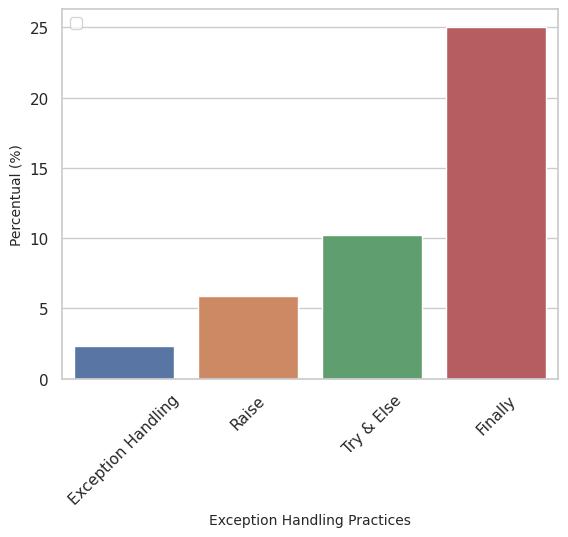

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

sns.barplot(data=df_total, x="index", y=0)
plt.ylabel("Percentual (%)", fontsize= 10)
plt.xlabel("Exception Handling Practices", fontsize= 10)
plt.tick_params(axis='x', rotation=45)
plt.legend(loc="best", ncol=3)
plt.title("", fontsize= 15)

In [86]:
df_except_types = df.str_except_identifiers.str.split(" ").explode().value_counts().reset_index()

In [88]:
df_except_types

,index,str_except_identifiers
0,Exception,691
1,ValueError,433
2,TypeError,433
3,KeyError,304
4,AttributeError,278
...,...,...
325,BlockingIOError,1
326,ObjMismatchError,1
327,ObjNotFoundError,1
328,UnsupportedInputs,1


In [72]:
#df_except_types = df_except_types[1:]

In [89]:
df_except_types.head(20)

,index,str_except_identifiers
0,Exception,691
1,ValueError,433
2,TypeError,433
3,KeyError,304
4,AttributeError,278
5,RuntimeError,181
6,ImportError,153
7,NotImplementedError,110
8,OSError,109
9,AssertionError,90


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, '')

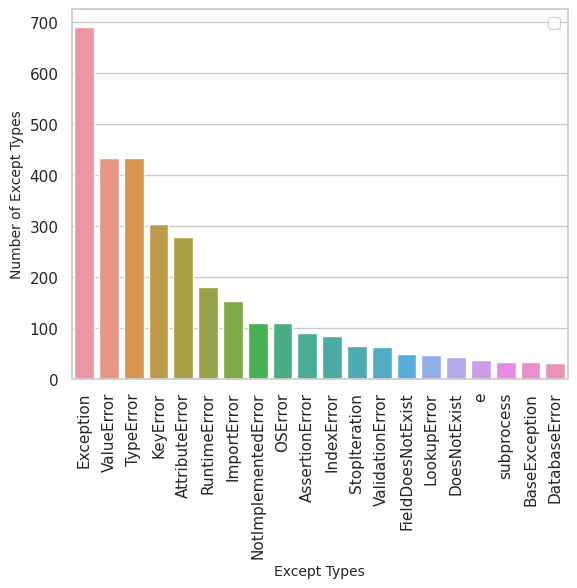

In [90]:
sns.set_theme(style="whitegrid")

fig = sns.barplot(data=df_except_types.head(20), x="index", y="str_except_identifiers").get_figure()
plt.ylabel("Number of Except Types", fontsize= 10)
plt.xlabel("Except Types", fontsize= 10)
plt.tick_params(axis='x', rotation=90)
plt.legend(loc="best", ncol=3)
plt.title("", fontsize= 15)


In [75]:
df_raise_types = df.str_raise_identifiers.str.split(" ").explode().value_counts().reset_index()
df_raise_types = df_raise_types[1:]
df_raise_types.head(20)

,index,str_raise_identifiers
1,RuntimeError,1528
2,TypeError,1040
3,NotImplementedError,920
4,Exception,386
5,AssertionError,325
6,ValidationError,179
7,KeyError,140
8,AttributeError,138
9,ImproperlyConfigured,111
10,CommandError,108


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, '')

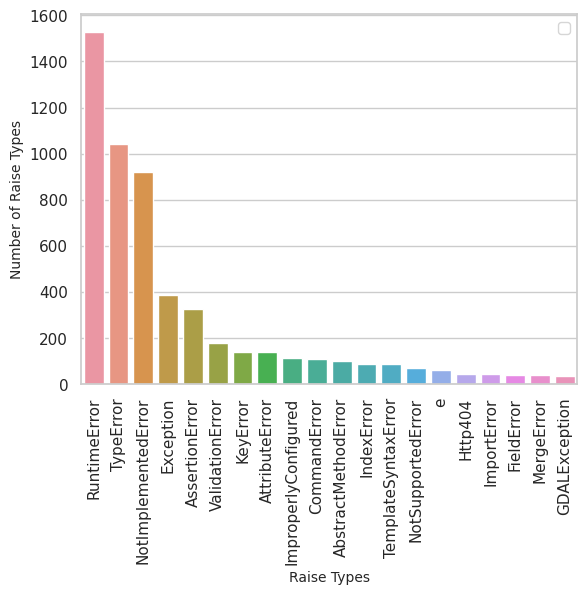

In [76]:
sns.set_theme(style="whitegrid")

fig = sns.barplot(data=df_raise_types.head(20), x="index", y="str_raise_identifiers").get_figure()
plt.ylabel("Number of Raise Types", fontsize= 10)
plt.xlabel("Raise Types", fontsize= 10)
plt.tick_params(axis='x', rotation=90)
plt.legend(loc="best", ncol=3)
plt.title("", fontsize= 15)


RQ2. 

In [77]:
cols = ['n_try_pass', 'n_generic_except', 'n_captures_try_except_raise', 'n_captures_broad_raise']

for col in cols:
    df[col+'_uni'] = df[col].apply(lambda x: 1 if x >= 1 else x)

In [78]:
df_rq2 = df.agg({'function': ['count'], 'n_try_except_uni': ['sum'], 'n_try_pass_uni': ['sum'], 'n_generic_except_uni': ['sum'], 'n_raise_uni': ['sum'], 'n_captures_try_except_raise_uni': ['sum'], 'n_captures_broad_raise_uni': ['sum']})
df_rq2 = df_rq2.max().to_frame().T

In [79]:
df_rq2

,function,n_try_except_uni,n_try_pass_uni,n_generic_except_uni,n_raise_uni,n_captures_try_except_raise_uni,n_captures_broad_raise_uni
0,119037.0,2767.0,481.0,579.0,7000.0,189.0,315.0


In [80]:
#Trys-Except
df_rq2['perc_n_try_pass_uni'] = (df_rq2['n_try_pass_uni']/ df_rq2['n_try_except_uni']) * 100
df_rq2['perc_n_generic_except_uni'] = (df_rq2['n_generic_except_uni']/ df_rq2['n_try_except_uni']) * 100

#Raise
df_rq2['perc_n_captures_try_except_raise_uni'] = (df_rq2['n_captures_try_except_raise_uni']/ df_rq2['n_raise_uni']) * 100
df_rq2['perc_n_captures_broad_raise_uni'] = (df_rq2['n_captures_broad_raise_uni']/ df_rq2['n_raise_uni']) * 100

df_rq2

,function,n_try_except_uni,n_try_pass_uni,n_generic_except_uni,n_raise_uni,n_captures_try_except_raise_uni,n_captures_broad_raise_uni,perc_n_try_pass_uni,perc_n_generic_except_uni,perc_n_captures_try_except_raise_uni,perc_n_captures_broad_raise_uni
0,119037.0,2767.0,481.0,579.0,7000.0,189.0,315.0,17.383448,20.92519,2.7,4.5


In [81]:
df_total_rq2 = df_rq2.loc[:, ["perc_n_try_pass_uni", "perc_n_generic_except_uni", "perc_n_captures_try_except_raise_uni", "perc_n_captures_broad_raise_uni"]]
df_total_rq2

,perc_n_try_pass_uni,perc_n_generic_except_uni,perc_n_captures_try_except_raise_uni,perc_n_captures_broad_raise_uni
0,17.383448,20.92519,2.7,4.5


In [82]:
df_total_rq2.columns = ['CWE-391', 'CWE-396', 'CWE-252', 'CWE-397']
df_total_rq2

,CWE-391,CWE-396,CWE-252,CWE-397
0,17.383448,20.92519,2.7,4.5


In [83]:
df_total_rq2 = df_total_rq2.T[0:].reset_index()
df_total_rq2

,index,0
0,CWE-391,17.383448
1,CWE-396,20.925190
2,CWE-252,2.700000
3,CWE-397,4.500000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, '')

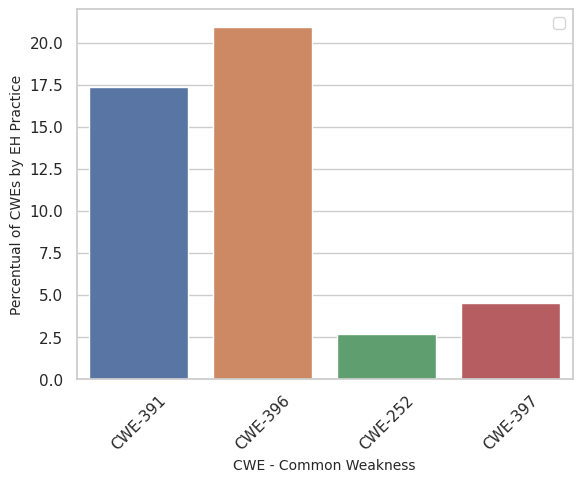

In [84]:
import seaborn as sns
sns.set_theme(style="whitegrid")

sns.barplot(data=df_total_rq2, x="index", y=0)
plt.ylabel("Percentual of CWEs by EH Practice", fontsize= 10)
plt.xlabel("CWE - Common Weakness", fontsize= 10)
plt.tick_params(axis='x', rotation=45)
plt.legend(loc="best", ncol=3)
plt.title("", fontsize= 15)